# Protocol adherence by red flag detection

*Notebook with python code for the analysis of experiment outputs.*

**Setup**

In [21]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, classification_report

**Data**

Loading:

In [4]:
df = pd.read_csv('./results/df_experiment_with_results_20231024.csv')

In [5]:
with open('./results/algorithms_time_20231024.pkl', 'rb') as handler:

    algorithms_time = pickle.load(handler)

In [6]:
df.tail(3)

,Unnamed: 0,CID,clinical_impression,simple_scorer,levenshtein_scorer,jaccard_scorer,bow_scorer
10119,10119,H00,Hórdeolo sem melhora com compressa. Necessidad...,"[('HORDÉOLO - ADULTO', 0.0)]","[('HORDÉOLO - ADULTO', 0.0)]","[('HORDÉOLO - ADULTO', 0.0)]","[('HORDÉOLO - ADULTO', 2.8533997271101787e-06)]"
10120,10120,J06,Necessita de avaliação presencial para exame f...,"[('NASOFARINGITE AGUDA - PEDIATRIA', 0.0)]","[('NASOFARINGITE AGUDA - PEDIATRIA', 0.3333)]","[('NASOFARINGITE AGUDA - PEDIATRIA', 0.0)]","[('NASOFARINGITE AGUDA - PEDIATRIA', 6.1869025..."
10121,10121,B34.2,Com sinais de alarme - dor torácica + dispneia,"[('COVID19', 0.6667)]","[('COVID19', 0.6667)]","[('COVID19', 0.2857142857142857)]","[('COVID19', 0.3138677232287016)]"


In [7]:
algorithms_time

[('simple_scorer', 48.912413120269775),
 ('levenshtein_scorer', 49.05565094947815),
 ('jaccard_scorer', 48.62057685852051),
 ('bow_scorer', 49.705008029937744)]

Wrangling:

In [8]:
df.simple_scorer = df.simple_scorer.apply( lambda x: max(eval(x), key = lambda z: z[1]) if len(eval(x)) > 0 else np.nan )
df.levenshtein_scorer = df.levenshtein_scorer.apply( lambda x: max(eval(x), key = lambda z: z[1]) if len(eval(x)) > 0 else np.nan )
df.jaccard_scorer = df.jaccard_scorer.apply( lambda x: max(eval(x), key = lambda z: z[1]) if len(eval(x)) > 0 else np.nan )
df.bow_scorer = df.bow_scorer.apply( lambda x: max(eval(x), key = lambda z: z[1]) if len(eval(x)) > 0 else np.nan )

In [9]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [10]:
df['label'] = [int(x) for x in df.CID.values == 'A90']

Downsampling counter example data:

In [11]:
def downsampler(iterations:int, metric:str, scorer:str):

    counter = 0
    output = list()

    sample_size = df.query('label == 1').shape[0]

    while counter < iterations:

        if metric.strip().lower() == 'mean':

            output.append(
                df.query('label == 0')[scorer].dropna().apply(lambda x: x[1]).sample( sample_size ).mean()
            )

        elif metric.strip().lower() == 'median':

            output.append(
                df.query('label == 0')[scorer].dropna().apply(lambda x: x[1]).sample( sample_size ).median()
            )

        else:

            raise NotImplementedError('`metric` should be either "mean" or "median".')

        counter += 1

    return output

In [12]:
counter_example_simple_scorer_mean = downsampler(iterations=1000, metric='mean', scorer='simple_scorer')

counter_example_levenshtein_scorer_mean = downsampler(iterations=1000, metric='mean', scorer='levenshtein_scorer')

counter_example_jaccard_scorer_mean = downsampler(iterations=1000, metric='mean', scorer='jaccard_scorer')

counter_example_bow_scorer_mean = downsampler(iterations=1000, metric='mean', scorer='bow_scorer')

Mean difference:

In [13]:
example_simple_scorer_mean = df.query('label == 1')['simple_scorer'].dropna().apply(lambda x: x[1]).mean()

example_levenshtein_scorer = df.query('label == 1')['levenshtein_scorer'].dropna().apply(lambda x: x[1]).mean()

example_jaccard_scorer = df.query('label == 1')['jaccard_scorer'].dropna().apply(lambda x: x[1]).mean()

example_bow_scorer = df.query('label == 1')['bow_scorer'].dropna().apply(lambda x: x[1]).mean()

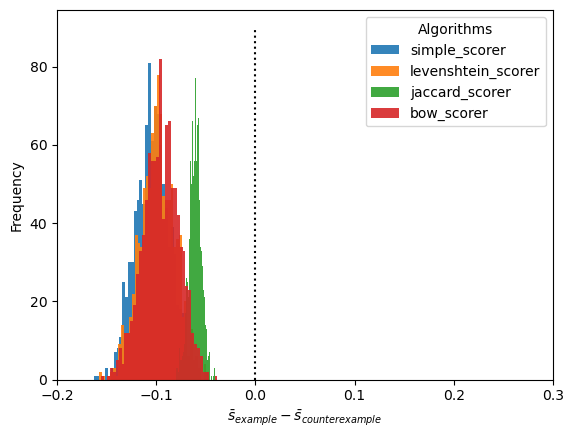

In [14]:
plt.hist(example_simple_scorer_mean - np.array(counter_example_simple_scorer_mean), bins=40, label='simple_scorer', alpha=0.9)
plt.hist(example_levenshtein_scorer - np.array(counter_example_levenshtein_scorer_mean), bins=40, label='levenshtein_scorer', alpha=0.9)
plt.hist(example_jaccard_scorer - np.array(counter_example_jaccard_scorer_mean), bins=40, label='jaccard_scorer', alpha=0.9)
plt.hist(example_bow_scorer - np.array(counter_example_bow_scorer_mean), bins=40, label='bow_scorer', alpha=0.9)

plt.legend()

plt.vlines(0, 0, 90, color='black', linestyles='dotted')
plt.xlim(-0.2, 0.3)

plt.xlabel(r'$\bar{s}_{example} - \bar{s}_{counter example}$')
plt.ylabel('Frequency')

plt.legend(bbox_to_anchor=(1,1), title='Algorithms')

Complete data plots:

/var/folders/bq/7mkkfrfd3fjd2wrwp70xz_l9fwyk_9/T/ipykernel_10936/511510968.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(['Counter example','Example'])


Text(0, 0.5, 'Adherence score')

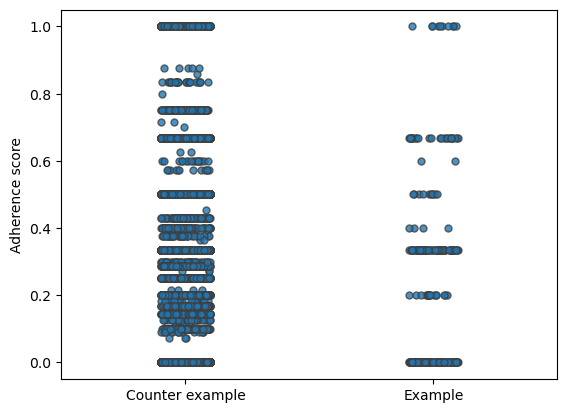

In [15]:
g = sns.stripplot(
    x = df.dropna()['label'],
    y = df.dropna()['simple_scorer'].apply(lambda x: x[1]),
    alpha = 0.8,
    linewidth = 1
)

g.set_xticklabels(['Counter example','Example'])

plt.xlabel('')
plt.ylabel('Adherence score')

/var/folders/bq/7mkkfrfd3fjd2wrwp70xz_l9fwyk_9/T/ipykernel_10936/3344789563.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(['Counter example','Example'])


Text(0, 0.5, 'Adherence score')

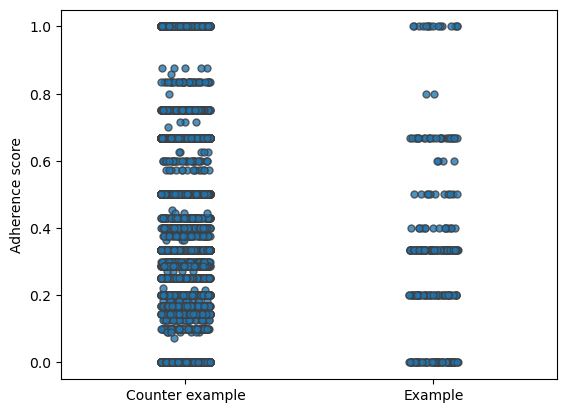

In [16]:
g = sns.stripplot(
    x = df.dropna()['label'],
    y = df.dropna()['levenshtein_scorer'].apply(lambda x: x[1]),
    alpha = 0.8,
    linewidth = 1
)

g.set_xticklabels(['Counter example','Example'])

plt.xlabel('')
plt.ylabel('Adherence score')

/var/folders/bq/7mkkfrfd3fjd2wrwp70xz_l9fwyk_9/T/ipykernel_10936/1632376287.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(['Counter example','Example'])


Text(0, 0.5, 'Adherence score')

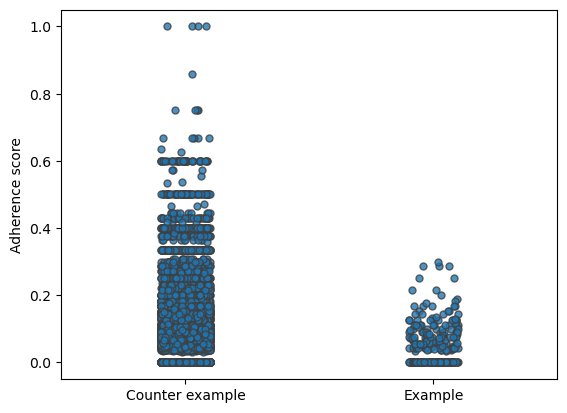

In [17]:
g = sns.stripplot(
    x = df.dropna()['label'],
    y = df.dropna()['jaccard_scorer'].apply(lambda x: x[1]),
    alpha = 0.8,
    linewidth = 1
)

g.set_xticklabels(['Counter example','Example'])

plt.xlabel('')
plt.ylabel('Adherence score')

/var/folders/bq/7mkkfrfd3fjd2wrwp70xz_l9fwyk_9/T/ipykernel_10936/4124358561.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(['Counter example','Example'])


Text(0, 0.5, 'Adherence score')

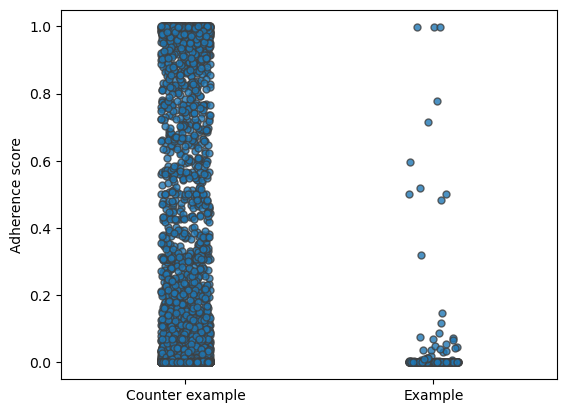

In [18]:
g = sns.stripplot(
    x = df.dropna()['label'],
    y = df.dropna()['bow_scorer'].apply(lambda x: x[1]),
    alpha = 0.8,
    linewidth = 1
)

g.set_xticklabels(['Counter example','Example'])

plt.xlabel('')
plt.ylabel('Adherence score')

Thresholding:

In [19]:
def best_threshold(y_true, y_pred):

    output = list()

    for alpha in np.arange(0, 1, 0.01):

        value = f1_score(
            y_true, 
            (y_pred >= alpha)
        )

        output.append( (alpha, value) )

    best_values = max(output, key=lambda k: k[1])

    return {'best-threshold': best_values[0], 'F1-score': best_values[1]}

In [22]:
simple_scorer_best_threshold = best_threshold(
    df.dropna().label, 
    df.dropna().simple_scorer.apply(lambda x: x[1])
)

simple_scorer_best_threshold

{'best-threshold': 0.0, 'F1-score': 0.051796319735176705}

In [23]:
levenshtein_scorer_best_threshold = best_threshold(
    df.dropna().label, 
    df.dropna().levenshtein_scorer.apply(lambda x: x[1])
)

levenshtein_scorer_best_threshold

{'best-threshold': 0.0, 'F1-score': 0.051796319735176705}

In [24]:
jaccard_scorer_best_threshold = best_threshold(
    df.dropna().label, 
    df.dropna().jaccard_scorer.apply(lambda x: x[1])
)

jaccard_scorer_best_threshold

{'best-threshold': 0.0, 'F1-score': 0.051796319735176705}

In [25]:
bow_scorer_best_threshold = best_threshold(
    df.dropna().label, 
    df.dropna().bow_scorer.apply(lambda x: x[1])
)

bow_scorer_best_threshold

{'best-threshold': 0.0, 'F1-score': 0.051796319735176705}

Classification reports:

* REMIND: you should pick the respective threshold values above and insert it accordingly int the below code.

In [26]:
print(
    classification_report(
        y_true = df.dropna().label.values,
        y_pred = (df['simple_scorer'].dropna().apply(lambda x: x[1]) >= 0.7).values
    )
)

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      9739
           1       0.01      0.04      0.02       266

    accuracy                           0.89     10005
   macro avg       0.49      0.48      0.48     10005
weighted avg       0.95      0.89      0.92     10005



In [27]:
print(
    classification_report(
        y_true = df.dropna().label.values,
        y_pred = (df['levenshtein_scorer'].dropna().apply(lambda x: x[1]) >= 0.37).values
    )
)

              precision    recall  f1-score   support

           0       0.97      0.58      0.72      9739
           1       0.02      0.28      0.03       266

    accuracy                           0.57     10005
   macro avg       0.49      0.43      0.38     10005
weighted avg       0.94      0.57      0.71     10005



In [28]:
print(
    classification_report(
        y_true = df.dropna().label.values,
        y_pred = (df['jaccard_scorer'].dropna().apply(lambda x: x[1]) >= 0.19).values
    )
)

              precision    recall  f1-score   support

           0       0.97      0.83      0.90      9739
           1       0.01      0.03      0.01       266

    accuracy                           0.81     10005
   macro avg       0.49      0.43      0.45     10005
weighted avg       0.94      0.81      0.87     10005



In [29]:
print(
    classification_report(
        y_true = df.dropna().label.values,
        y_pred = (df['bow_scorer'].dropna().apply(lambda x: x[1]) > 0.00001).values
    )
)

              precision    recall  f1-score   support

           0       0.97      0.36      0.53      9739
           1       0.03      0.61      0.05       266

    accuracy                           0.37     10005
   macro avg       0.50      0.48      0.29     10005
weighted avg       0.95      0.37      0.51     10005



Time complexity plot:

In [30]:
df_time = pd.DataFrame(algorithms_time, columns=['algorithm', 'time'])

In [31]:
df_time['F1-score'] = (
    simple_scorer_best_threshold['F1-score'], levenshtein_scorer_best_threshold['F1-score'], 
    jaccard_scorer_best_threshold['F1-score'], bow_scorer_best_threshold['F1-score']
)

In [32]:
df_time

,algorithm,time,F1-score
0,simple_scorer,48.912413,0.051796
1,levenshtein_scorer,49.055651,0.051796
2,jaccard_scorer,48.620577,0.051796
3,bow_scorer,49.705008,0.051796


Text(0.5, 0, 'Time (in seconds)')

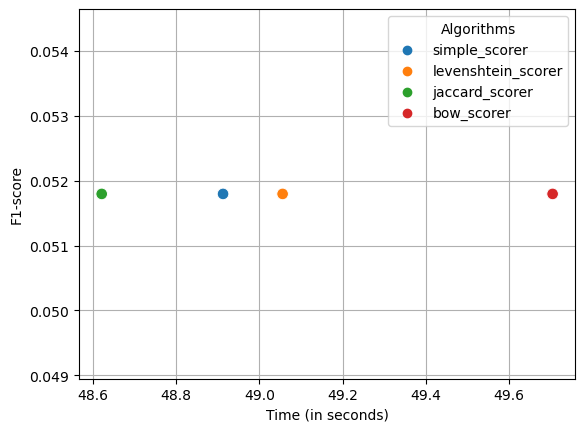

In [33]:
sns.scatterplot(
    x = 'time', y = 'F1-score', hue = 'algorithm',  s=70, legend=True, data=df_time #.iloc[:4]
)

plt.grid()

# plt.xscale('log')
# plt.yscale('log')

plt.legend(title='Algorithms') #, labels=['Simple scorer', 'Levenshtein scorer', 'Jaccard scorer', 'Bow scorer', 'Sentence transformer scorer'])
plt.xlabel('Time (in seconds)')